# Forecast transit time

In this notebook we are going to train a model to forecast the transit time of a Coronal Mass Ejection (CME) from the Sun to Earth. This is a regression task, so each CME event is associated with the value of the transit time from the Sun to Earth, calculated as the difference between the take-off time and the arrival time. 

We will use a dataset already prepared by [Alobaid et al. 2022](https://www.frontiersin.org/articles/10.3389/fspas.2022.1013345/full) and available at the following [link](https://github.com/deepsuncode/CMETNet/blob/main/CMETNet_Package/data/ICME_list.csv).


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [18]:
# Download the dataset:
link = 'https://raw.githubusercontent.com/deepsuncode/CMETNet/main/CMETNet_Package/data/ICME_list.csv'

In [19]:
# Read the dataset with pandas:
try:
    df = pd.read_csv('transitTime/ICME_list.csv')
except:
    import urllib.request
    import os
    os.makedirs('transitTime', exist_ok=True)
    urllib.request.urlretrieve(link, 'transitTime/ICME_list.csv')
    df = pd.read_csv('transitTime/ICME_list.csv')

# Drop those with more than 120 days of transit time:
df = df[df['transit_time'] <= 120]

In [20]:
df

,disturbance,transit_time,angular_width,MPA,avg_speed,final_speed,mass,BX,BZ_GSE,Plasma_Temp,Plasma_Speed,Plasma_flow_long,Alpha_Prot_ratio,flow_pressure
0,1996-08-14 19:30:00,36.0,235.0,237.0,691.0,394.0,3.100000e+15,-4.7,0.6,99883,480,0.9,0.040,2.59
1,1996-11-28 16:50:00,89.0,101.0,267.0,984.0,1180.0,4.000000e+15,-4.2,-0.9,31127,397,0.9,0.008,2.01
2,1996-12-19 16:30:00,95.0,130.0,265.0,469.0,394.0,5.100000e+14,0.4,0.1,14435,323,-3.3,0.006,0.87
3,1997-01-06 15:10:00,81.0,360.0,180.0,136.0,224.0,5.800000e+14,3.0,1.8,35501,367,-1.4,0.011,2.75
4,1997-02-07 00:30:00,60.0,360.0,266.0,490.0,718.0,4.100000e+15,1.8,2.3,34874,375,0.6,0.022,1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,2020-05-26 00:39:00,93.0,95.0,251.0,142.0,216.0,1.514321e+15,-1.8,-1.2,27956,327,0.1,0.005,1.38
359,2020-11-29 13:24:00,55.0,360.0,159.0,2077.0,2149.0,1.514321e+15,-3.9,2.3,26031,353,2.4,0.031,0.63
360,2020-12-07 16:24:00,57.0,360.0,194.0,1407.0,1308.0,1.514321e+15,-0.9,0.6,71201,353,2.7,0.040,0.60
361,2021-01-01 22:00:00,98.0,127.0,249.0,190.0,227.0,1.514321e+15,2.6,0.6,34768,340,0.4,0.033,1.14


## Data exploration:

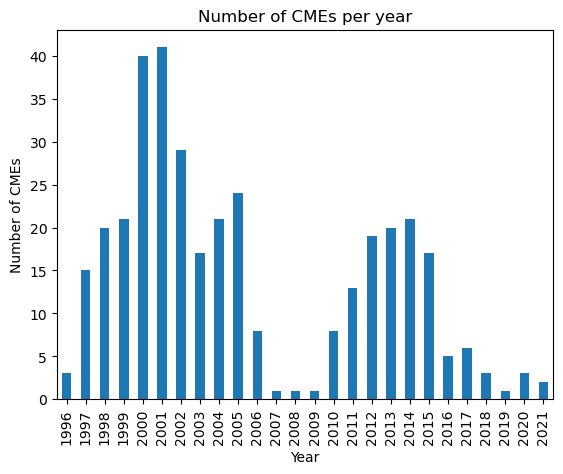

In [21]:
# Number of CMEs per year:
df['year'] = pd.to_datetime(df['disturbance']).dt.year
df['year'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of CMEs')
plt.title('Number of CMEs per year')
# delete the year column
df = df.drop(columns=['year'])

Text(0.5, 1.0, 'CME transit time distribution')

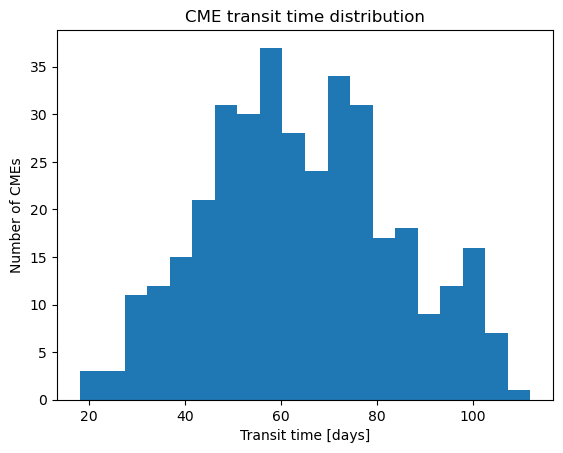

In [22]:
# CME transit time distribution:
df['transit_time'].plot(kind='hist', bins=20)
plt.xlabel('Transit time [days]')
plt.ylabel('Number of CMEs')
plt.title('CME transit time distribution')


In [23]:
# Regression analysis:
from sklearn.linear_model import LinearRegression

# ydata, the target variable:
ydata = df['transit_time'].values

# xdata, the rest of the features:
xdata = df.drop(columns=['disturbance', 'transit_time']).values
feature_names = df.drop(columns=['disturbance', 'transit_time']).columns


## Regression task:

To test the performance of several models we will use a linear regressor, and an artificial neural network.

Text(0.5, 1.0, 'Linear regression coefficients')

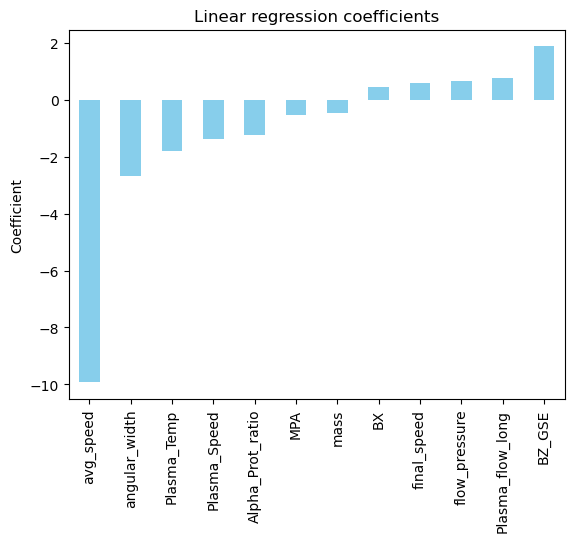

In [24]:
# Standarization of the features:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

xdata_scaled = scaler.fit_transform(xdata)



# Linear regression:
model = LinearRegression()
model.fit(xdata_scaled, ydata)

# Coefficients, sorted vertically:
coefficients = pd.Series(model.coef_, index=feature_names).sort_values()
coefficients.plot(kind='bar', color='skyblue')
plt.ylabel('Coefficient')
plt.title('Linear regression coefficients')
# plt.xticks(rotation=45)


It looks that there is one feature that is very important for the transit time of CMEs. Let's see which one it is:


In [25]:
largestcoef = np.argmax(np.abs(model.coef_))
print(f'The most important feature is {feature_names[largestcoef]} with a coefficient of {model.coef_[largestcoef]:.2f}')

The most important feature is avg_speed with a coefficient of -9.93


R2 score: 0.3906771570698454
MSE: 231.8551275268057


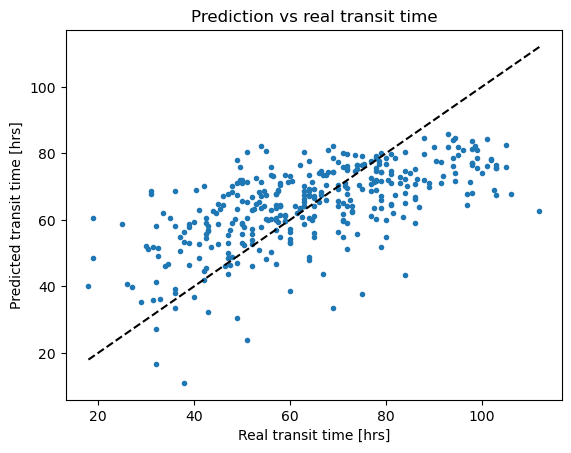

In [26]:
# Prediction vs real transit time:
y_pred = model.predict(xdata_scaled)
plt.scatter(ydata, y_pred, marker='.')   # scatter plot
plt.xlabel('Real transit time [hrs]')
plt.ylabel('Predicted transit time [hrs]')
plt.title('Prediction vs real transit time')
plt.plot([ydata.min(), ydata.max()], [ydata.min(), ydata.max()], color='k', linestyle='--')   # diagonal line

print('R2 score:', model.score(xdata_scaled, ydata))
print('MSE:', np.mean((ydata - y_pred)**2))

R2 score: 0.4862090413869259
MSE: 195.50402485896808


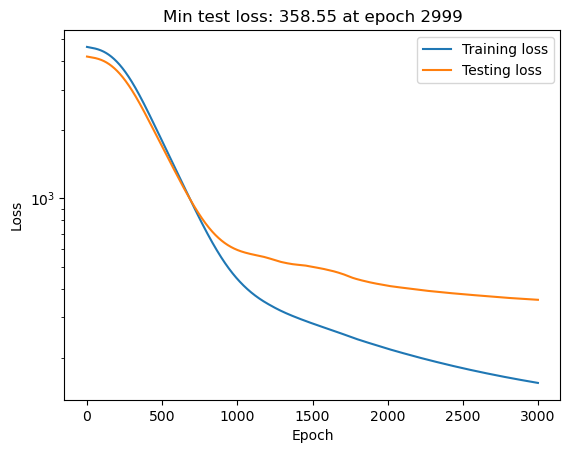

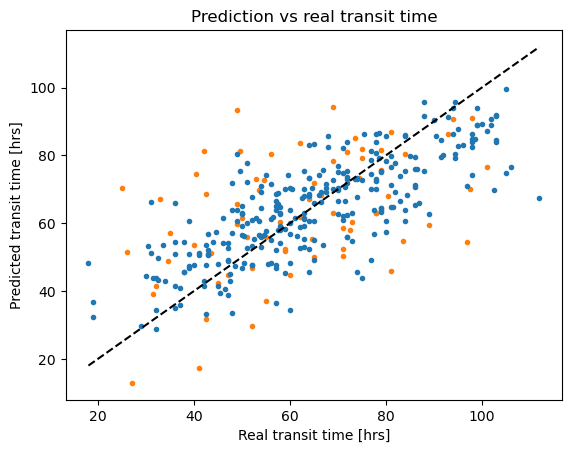

In [27]:
# Artificial neural network with pytorch:
import torch
import torch.nn as nn
import torch.optim as optim

# Neural network:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 1)
        self.activation = nn.ELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x
    
    def fit(self, xdata, ydata, epochs=1000, lr=0.01, verbose=True, xtest=None, ytest=None):
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        
        xdata_tensor = torch.tensor(xdata, dtype=torch.float32)
        ydata_tensor = torch.tensor(ydata, dtype=torch.float32).reshape(-1, 1)
        
        if xtest is not None and ytest is not None:
            xtest_tensor = torch.tensor(xtest, dtype=torch.float32)
            ytest_tensor = torch.tensor(ytest, dtype=torch.float32).reshape(-1, 1)
        
        loss_train = []
        loss_test = []
        
        for epoch in range(epochs):
            optimizer.zero_grad()
            output = self(xdata_tensor)
            loss = criterion(output, ydata_tensor)
            loss.backward()
            optimizer.step()
            loss_train.append(loss.item())
            
            if epoch % 100 == 0 and verbose:
                print(f'Epoch {epoch}, loss: {loss.item()}', flush=True)
            
            if xtest is not None and ytest is not None:
                loss_test.append(criterion(self(xtest_tensor), ytest_tensor).item())
        
        return loss_train, loss_test
                
                
    def predict(self, xdata):
        xdata_tensor = torch.tensor(xdata, dtype=torch.float32)
        return self(xdata_tensor).detach().numpy().ravel()
    
    def score(self, xdata, ydata):
        y_pred = self.predict(xdata)
        return 1 - np.mean((ydata - y_pred)**2) / np.mean((ydata - ydata.mean())**2)

model = Net(input_size=xdata.shape[1])

# Split the data into training and testing:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(xdata_scaled, ydata, test_size=0.2, random_state=42)


loss_train, loss_test = model.fit(xtrain, ytrain, epochs=3000, lr=0.001, verbose=False, xtest=xtest, ytest=ytest)

plt.plot(loss_train, label='Training loss')
plt.plot(loss_test, label='Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Min test loss: {:.2f} at epoch {}'.format(min(loss_test), np.argmin(loss_test)))
plt.yscale('log')
plt.legend()



# Prediction vs real transit time:
plt.figure()
y_predtest = model.predict(xtest)
plt.scatter(ytest, y_predtest, color='C1', marker='.')   # scatter plot
y_predtrain = model.predict(xtrain)
plt.scatter(ytrain, y_predtrain, color='C0', marker='.')   # scatter plot

plt.xlabel('Real transit time [hrs]')
plt.ylabel('Predicted transit time [hrs]')
plt.title('Prediction vs real transit time')
plt.plot([ydata.min(), ydata.max()], [ydata.min(), ydata.max()], color='k', linestyle='--')   # diagonal line

y_pred = model.predict(xdata_scaled)
print('R2 score:', model.score(xdata_scaled, ydata))
print('MSE:', np.mean((ydata - y_pred)**2))

## Using the kernel trick:

One could try to create new feautures by using the kernel trick. This is a way to create new features by using the dot product of the original features. But also other combinations with non-linear functions like log, cos, etc. In fact, this is what the neural network does when it uses non-linear activation functions.

## Symbolic regression using pySR:

In the previous case we used a linear regressor and an artificial neural network. The linear regressor has high interpretability but low performance, while the artificial neural network has high performance but low interpretability. In this case we will use symbolic regression to find a mathematical expression that relates the input features to the target variable, so we can have a model with good average performance and good interpretability.

The idea of symbolic regression is to find a mathematical expression that relates the input features to the target variable. The symbolic regression algorithm will search for the best mathematical expression that fits the data, and the result will be a mathematical expression that can be used to predict the target variable. These expressions are ordered in terms of complexity and performance, so we can choose the best expression that fits our needs.

In [28]:
try:
    import pysr
except:
   %pip install pysr
   import pysr 
    

In [29]:
from pysr import PySRRegressor

model = PySRRegressor(niterations=200, binary_operators=["*", "+", "-", "/", "^"], elementwise_loss="loss(predictions, target) = abs(predictions - target)", warm_start=True, constraints={'^': (-1, 3)})
model.fit(xdata_scaled, ydata)


/Users/carlosjd/anaconda3/envs/pykdb/lib/python3.10/site-packages/pysr/sr.py:1297: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/carlosjd/anaconda3/envs/pykdb/lib/python3.10/site-packages/pysr/sr.py:1874: UserWarning: Note: you are running with 10 features or more. Genetic algorithms like used in PySR scale poorly with large numbers of features. You should run PySR for more `niterations` to ensure it can find the correct variables, or, alternatively, do a dimensionality reduction beforehand. For example, `X = PCA(n_components=6).fit_transform(X)`, using scikit-learn's `PCA` class, will reduce the number of features to 6 in an interpretable way, as each resultant feature will be a linear combination of the original features. 
  warnings.warn(
[ Info: Started!


Expressions evaluated per second: 4.480e+05
Head worker occupation: 8.7%
Progress: 931 / 3000 total iterations (31.033%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.603e+01  1.594e+01  y = 63.867
3           1.556e+01  1.496e-02  y = (63.173 - x₂)
5           1.226e+01  1.190e-01  y = (61.948 ^ (0.94168 ^ x₂))
7           1.214e+01  5.078e-03  y = ((61.948 - x₇) ^ (0.94168 ^ x₂))
9           1.206e+01  3.165e-03  y = (((61.948 - x₇) ^ (0.94168 ^ x₂)) + x₃)
11          1.199e+01  3.088e-03  y = ((((61.948 - x₇) ^ (0.94168 ^ x₂)) - x₈) + x₃)
13          1.192e+01  2.658e-03  y = ((((61.948 - x₇) + x₆) ^ (0.94168 ^ x₂)) + (x₃ - x₀))
15          1.185e+01  3.106e-03  y = (((((61.948 - x₇) + x₆) - x₈) ^ (0.94168 ^ x₂)) + (x₂ - x₀...
                                  ))
17          1.181e+01  1.873e-03  y = ((((((61.948 - 1.3872) - x₇) + x₆) - x₈) ^ (0.94168 ^ x₂))...

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                          63.867046   
	1        0.014965                                   (63.172867 - x2)   
	2  >>>>  0.120631                     (61.50235 ^ (0.94481295 ^ x2))   
	3        0.004946               ((61.29113 ^ (0.9451159 ^ x2)) - x7)   
	4        0.004655  ((60.91201 - (x7 / 0.33468518)) ^ (0.94481295 ...   
	5        0.004015  ((60.91201 - ((x8 - x6) / 0.33468518)) ^ (0.94...   
	6        0.002947  (((60.91201 - ((x8 - x6) / 0.33468518)) ^ (0.9...   
	7        0.003530  (((60.91201 - ((x8 - x6) / 0.33468518)) ^ (0.9...   
	8        0.003839  (((60.91201 - ((x8 - x6) / 0.33468518)) ^ (0.9...   
	9        0.003391  (((60.91201 - ((0.33468518 - (x6 - x7)) / 0.33...   
	
	        loss  complexity  
	0  16.030552           1  
	1  15.557875           3  
	2  12.222822           5  
	3  12.102498           7  
	4  11.990355           9  
	5  11.894469          11  
	6  11.824563          13  
	7  11.741368          15  
	8  11.651554          17  
	9  11.572811          19  
]

In [30]:
# Equation with the largest score:
model.equations_.iloc[model.equations_['score'].idxmax()]

complexity                                                 5
loss                                               12.222822
score                                               0.120631
equation                      (61.50235 ^ (0.94481295 ^ x2))
sympy_format                      61.50235**(0.94481295**x2)
lambda_format    PySRFunction(X=>61.50235**(0.94481295**x2))
Name: 2, dtype: object

R2 score: 0.38293950926655496
MSE: 234.79940138590186


Text(0.1, 0.9, '(61.50235 ^ (0.94481295 ^ x2))')

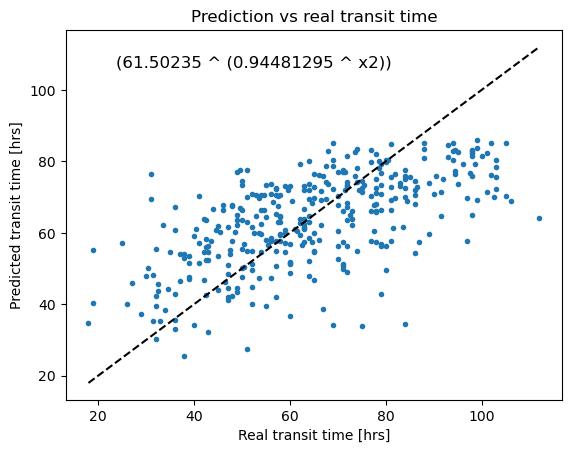

In [31]:
# Prediction vs real transit time:
plt.figure()
y_pred = model.predict(xdata_scaled)
plt.scatter(ydata, y_pred, marker='.')   # scatter plot
plt.xlabel('Real transit time [hrs]')
plt.ylabel('Predicted transit time [hrs]')
plt.title('Prediction vs real transit time')
plt.plot([ydata.min(), ydata.max()], [ydata.min(), ydata.max()], color='k', linestyle='--')   # diagonal line

print('R2 score:', model.score(xdata_scaled, ydata))
print('MSE:', np.mean((ydata - y_pred)**2))

# Write the text on the plot:
eq_name = model.equations_.iloc[model.equations_['score'].idxmax()].equation
plt.text(0.1, 0.9, eq_name, fontsize=12, transform=plt.gca().transAxes)
